In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import math
import os

#libairies pour le réseau de neurone
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pathlib

In [14]:
def import_table () : 
    """
    INPUT : path
    
    GOAL : This function ask the user to enter a rooth path for exploiting the dataset, return a pandas dataframe
    
    RETURN : The dataframe base
    
    """
    rooth = input("Veuillez rentrer un chemin de fichier: " )
    diamond = pd.read_csv(rooth + '/diamond_final.csv', index_col=0)
    return diamond

In [15]:
import_table()

Veuillez rentrer un chemin de fichier: /content/drive/MyDrive/Colab Notebooks


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,1,2,7,61.5,55.0,326,3.95,3.98,2.43
1,0.21,2,2,6,59.8,61.0,326,3.89,3.84,2.31
2,0.23,4,2,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,2,6,5,62.4,58.0,334,4.20,4.23,2.63
4,0.31,4,7,7,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,1,1,6,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,4,1,6,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,3,1,6,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,2,5,7,61.0,58.0,2757,6.15,6.12,3.74


In [20]:
train_dataset = diamond.sample(frac=0.8,random_state=0)
test_dataset = diamond.drop(train_dataset.index)

In [21]:
#Observation des statistiques globales
train_stats = train_dataset.describe()
train_stats.pop("price")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
carat,43152.0,0.797184,0.473724,0.2,0.40,0.70,1.04,5.01
cut,43152.0,2.092649,1.115636,1.0,1.00,2.00,3.00,5.00
color,43152.0,3.600459,1.706301,1.0,2.00,4.00,5.00,7.00
clarity,43152.0,4.940605,1.649229,1.0,4.00,5.00,6.00,8.00
depth,43152.0,61.747900,1.430988,43.0,61.00,61.80,62.50,79.00
table,43152.0,57.455726,2.233570,44.0,56.00,57.00,59.00,95.00
x,43152.0,5.728950,1.122392,0.0,4.71,5.69,6.54,10.74
y,43152.0,5.732241,1.142865,0.0,4.72,5.71,6.53,58.90
z,43152.0,3.537722,0.708590,0.0,2.91,3.52,4.03,31.80


In [22]:
#Suppression de la variable cible
train_labels = train_dataset.pop('price')
test_labels = test_dataset.pop('price')

In [23]:
#Standardisation
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [24]:
# das neuronale Netz mit seinen Schichten wird gebildet
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse', # optimisation avec l'erreur quadratique moyenne
                optimizer=optimizer,
                metrics=['mae', 'mse']) # évaluation avec les métriques mae et mse
  return model

In [25]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [29]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.1617822 ],
       [-0.15354039],
       [-0.05490431],
       [-0.09151143],
       [ 0.02603949],
       [ 0.3526132 ],
       [ 0.5698504 ],
       [ 0.06201915],
       [-0.264028  ],
       [ 0.2755963 ]], dtype=float32)

In [30]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

#EPOCHS = 300 
EPOCHS = 50
#EPOCHS = 150
#En raison de la taille énorme de notre jeu de données, il n'est pas nécessaire d'avoir beaucoup d'époques pour le calcul
#Pour chaque époque, l'ensemble des données de training est appliqué
history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])
#20% des 80% de données d'entraînement sont utilisés pour l'étape de validation

## Les valeurs MAE de différentes époques ou de leurs dépenses ont été comparées (epoch 50, 150 et 300)


..................................................

In [31]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
45,532375.43750,353.864532,532375.43750,3013621.25,359.719269,3013621.25,45
46,529180.18750,353.114349,529180.18750,3023319.00,357.414307,3023319.00,46
47,525895.56250,351.497742,525895.56250,3102503.50,355.786499,3102503.50,47
48,520366.40625,351.121613,520366.40625,3100195.00,353.670563,3100195.00,48
49,519611.84375,350.373840,519611.84375,3093568.75,354.399567,3093568.75,49


In [32]:
hist.to_csv('result_NN.csv')
#Données des époques enregistrées dans un nouveau fichier CSV et calcul de la valeur moyenne du MAE sur 10 passages

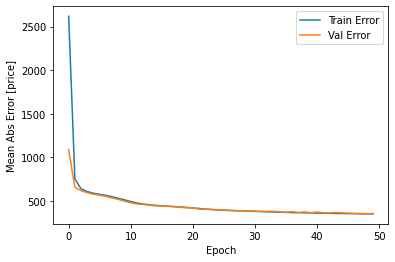

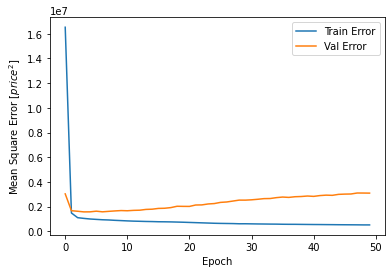

In [34]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [price]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()
#Le MAE est calculé ici pour chaque époque pour les données de formation et de validation
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$price^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()
plot_history(history)


..............

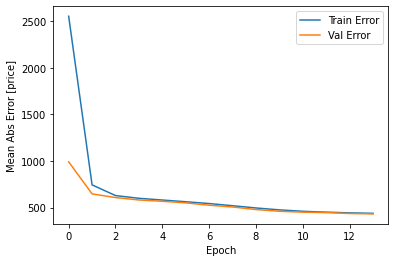

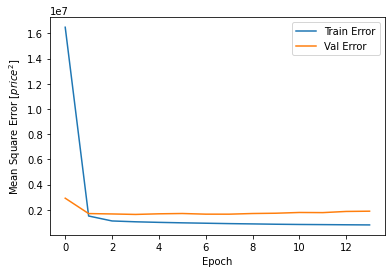

In [35]:
model = build_model()

# Le paramètre patience est le nombre d'époques pour vérifier l'amélioration
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [36]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} price".format(mae))

338/338 - 0s - loss: 949954.0000 - mae: 440.6298 - mse: 949954.0000 - 371ms/epoch - 1ms/step
Testing set Mean Abs Error: 440.63 price


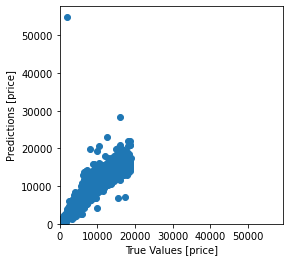

In [37]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [price]')
plt.ylabel('Predictions [price]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

#L'axe des x montre les valeurs réelles et l'axe des y nos prédictions.
#En principe, plus les diamants sont chers, plus les prévisions sont avantageuses qu'elles ne le sont en réalité.
#Plus les diamants sont beaux, plus ils sont rares et plus ils sont chers.
#Exemple : un diamant de 20 000 USD est parfois estimé à 12 000 USD, ce qui montre que les prévisions sont inférieures à la valeur réelle.
#expliquer les valeurs aberrantes, ce serait intéressant
#ajuster le graphique


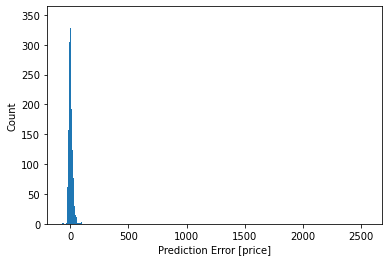

In [38]:
error = test_predictions - test_labels
#Le pourcentage est calculé, il est plus facile à interpréter qu'un USD
perc_error = ((error/(test_labels))*100)

plt.hist(perc_error, bins = 2500)
plt.xlabel("Prediction Error [price]")
_ = plt.ylabel("Count")